In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 64
img_size = 64
gen_embed_size = 100
disc_embed_size = img_size * img_size
num_channels = 1
num_classes = 10
z_dim = 100
features_gen = 64
features_disc = 64
lr = 2.0e-4
alpha = 0.2
num_epochs = 50
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.ToTensor(),
    transforms.Normalize(
    [0.5 for _ in range(num_channels)], [0.5 for _ in range(num_channels)])
])

In [4]:
dataset = datasets.MNIST(root='../../DATASETS', train=True, download=True, transform = transform )
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, drop_last = True )

In [5]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class Condition(nn.Module):
    def __init__(self, num_classes: int, embed_size: int, alpha: float, mode = 'gen'):
        super().__init__()
        self.mode = mode

        # From one-hot encoding to features: 10 => 784
        if self.mode == 'gen':
            self.fc = nn.Sequential(
                nn.Linear(num_classes, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU())
        else:
            self.fc = nn.Sequential(
                nn.Linear(num_classes, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.LeakyReLU(alpha))
            

    def forward(self, labels: torch.Tensor):
        # One-hot encode labels
        x = F.one_hot(labels, num_classes=10)

        # From Long to Float
        x = x.float()

        # To feature vectors
        if self.mode == 'gen':
            return self.fc(x).unsqueeze(2).unsqueeze(3)
        else:
            x = self.fc(x)
            batch_size = x.shape[0]
            return x.reshape(batch_size, 1, img_size, img_size)
            

In [7]:
images, labels = next(iter(dataloader))
c = Condition(num_classes, 64*64, alpha)(labels)
print(c.shape)

torch.Size([64, 4096, 1, 1])


In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, features_gen, num_channels, embed_size, alpha):
        super().__init__()
        self.z_dim = z_dim
        self.features_gen = features_gen
        self.num_channels = num_channels
        self.embed_size = embed_size
        self.alpha = alpha
        
        self.embed = Condition(num_classes, embed_size, alpha, mode = 'gen')
        
        self.net = nn.Sequential(
            self._block(in_channels=z_dim, out_channels=features_gen*16, kernel_size=4, stride=1, padding=0),
            self._block(features_gen*16, features_gen*8, 4, 2, 1),
            self._block(features_gen*8, features_gen*4, 4, 2, 1),
            self._block(features_gen*4, features_gen*2, 4, 2, 1),
            nn.ConvTranspose2d(features_gen*2, num_channels, 4, 2, 1),
            nn.Tanh())
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x, labels):
        embed = self.embed(labels)
        x = x + embed # Conditioned input
        return self.net(x)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, features_disc, num_channels, alpha, embed_size):
        super().__init__()
        self.z_dim = z_dim
        self.features_disc = features_disc
        self.num_channels = num_channels
        self.alpha = alpha
        self.labels = labels
        self.embed_size = embed_size
        
        # Input size --> 64, 1, 64, 64
        
        self.embed = Condition(num_classes, embed_size, alpha, mode = 'disc')
        
        
        self.net = nn.Sequential(
                self._block(num_channels, features_disc*2, 4, 2, 1),
                self._block(features_disc*2, features_disc*4, 4, 2, 1),
                self._block(features_disc*4, features_disc*8, 4, 2, 1),
                self._block(features_disc*8, features_disc*16, 4, 2, 1),
                nn.Conv2d(features_disc*16, 1, 4, 2, 0),
                nn.Sigmoid()       
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha)
        )
    
    def forward(self, x, labels):
        embed = self.embed(labels) # Condition
        x = x + embed # Conditioned input
        return self.net(x).reshape(-1, 1)

In [10]:
x = torch.randn(64, 1, 64, 64).to(device)
model = Discriminator(z_dim, features_disc, num_channels, alpha, disc_embed_size).to(device)
images, labels = next(iter(dataloader))
labels = labels.to(device)
out = model(x, labels)
print(out.shape)

torch.Size([64, 1])


/data1/home/ict11/miniconda3/envs/Torch_Gans/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [11]:
gen = Generator(z_dim, features_gen,  num_channels, gen_embed_size, alpha).to(device)
disc = Discriminator(z_dim, features_disc, num_channels, alpha, disc_embed_size).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [12]:
gen_optim = optim.Adam(params=gen.parameters(), lr = lr, betas=(0.5, 0.999))
disc_optim = optim.Adam(params=disc.parameters(), lr = lr, betas=(0.5, 0.999))
criterion = criterion = nn.BCELoss().to(device)
fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
real_targets = torch.ones(batch_size, 1).to(device)
fake_targets = torch.zeros(batch_size, 1).to(device)

In [13]:
# # To save images in grid layout
# def save_image_grid(epoch: int, images: torch.Tensor, ncol: int):
    
#     image_grid = make_grid(images, ncol, normalize=True)     # Images in a grid
#     image_grid = image_grid.permute(1, 2, 0) # Move channel last
#     image_grid = image_grid.cpu().numpy()    # To Numpy

#     plt.imshow(image_grid)
#     plt.xticks([])
#     plt.yticks([])
#     plt.savefig(f'GENERATED_IMAGES/MNIST/generated_{epoch+1:03d}.jpg') # MNIST GENERATED IMAGES
#     plt.close()

In [15]:
def save_image_grid(epoch: int, images: torch.Tensor, ncol: int, type = 'fake'):
    
    image_grid = make_grid(images, ncol, normalize=True)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    return image_grid

In [16]:
def plot_images(generated_image, real_image, epoch):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(generated_image)
    ax[0].set_xlabel("Generated Images")
    ax[1].imshow(real_image)
    ax[1].set_xlabel("Real Images")
    plt.savefig(f'GENERATED_IMAGES/MNIST/generated_{epoch+1:03d}.jpg')

100%|██████████| 937/937 [00:46<00:00, 20.22it/s]


EPOCH: 1 | G_LOSS: 2.597 | D_LOSS: 0.706


100%|██████████| 937/937 [00:45<00:00, 20.38it/s]


EPOCH: 2 | G_LOSS: 2.526 | D_LOSS: 0.820


100%|██████████| 937/937 [00:46<00:00, 20.34it/s]


EPOCH: 3 | G_LOSS: 2.930 | D_LOSS: 0.696


100%|██████████| 937/937 [00:45<00:00, 20.37it/s]


EPOCH: 4 | G_LOSS: 3.063 | D_LOSS: 0.652


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 5 | G_LOSS: 3.160 | D_LOSS: 0.622


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 6 | G_LOSS: 3.411 | D_LOSS: 0.486


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 7 | G_LOSS: 3.838 | D_LOSS: 0.337


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 8 | G_LOSS: 3.554 | D_LOSS: 0.569


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 9 | G_LOSS: 3.369 | D_LOSS: 0.583


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 10 | G_LOSS: 3.645 | D_LOSS: 0.519


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 11 | G_LOSS: 3.941 | D_LOSS: 0.445


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 12 | G_LOSS: 4.109 | D_LOSS: 0.392


100%|██████████| 937/937 [00:46<00:00, 20.37it/s]


EPOCH: 13 | G_LOSS: 4.438 | D_LOSS: 0.320


100%|██████████| 937/937 [00:46<00:00, 20.37it/s]


EPOCH: 14 | G_LOSS: 4.638 | D_LOSS: 0.318


100%|██████████| 937/937 [00:45<00:00, 20.38it/s]


EPOCH: 15 | G_LOSS: 4.772 | D_LOSS: 0.256


100%|██████████| 937/937 [00:46<00:00, 20.37it/s]


EPOCH: 16 | G_LOSS: 4.821 | D_LOSS: 0.205


100%|██████████| 937/937 [00:45<00:00, 20.37it/s]


EPOCH: 17 | G_LOSS: 4.779 | D_LOSS: 0.219


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 18 | G_LOSS: 4.770 | D_LOSS: 0.186


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 19 | G_LOSS: 4.924 | D_LOSS: 0.186


100%|██████████| 937/937 [00:45<00:00, 20.37it/s]
/tmp/ipykernel_3172367/2403066188.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1, 2)


EPOCH: 20 | G_LOSS: 4.574 | D_LOSS: 0.372


100%|██████████| 937/937 [00:45<00:00, 20.37it/s]


EPOCH: 21 | G_LOSS: 5.002 | D_LOSS: 0.248


100%|██████████| 937/937 [00:45<00:00, 20.38it/s]


EPOCH: 22 | G_LOSS: 5.284 | D_LOSS: 0.200


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 23 | G_LOSS: 5.523 | D_LOSS: 0.134


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 24 | G_LOSS: 5.479 | D_LOSS: 0.141


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 25 | G_LOSS: 5.652 | D_LOSS: 0.166


100%|██████████| 937/937 [00:46<00:00, 20.37it/s]


EPOCH: 26 | G_LOSS: 5.240 | D_LOSS: 0.163


100%|██████████| 937/937 [00:46<00:00, 20.31it/s]


EPOCH: 27 | G_LOSS: 5.753 | D_LOSS: 0.144


100%|██████████| 937/937 [00:46<00:00, 20.34it/s]


EPOCH: 28 | G_LOSS: 5.592 | D_LOSS: 0.146


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 29 | G_LOSS: 5.352 | D_LOSS: 0.174


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 30 | G_LOSS: 5.679 | D_LOSS: 0.169


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 31 | G_LOSS: 5.269 | D_LOSS: 0.299


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 32 | G_LOSS: 5.587 | D_LOSS: 0.225


100%|██████████| 937/937 [00:46<00:00, 20.35it/s]


EPOCH: 33 | G_LOSS: 5.837 | D_LOSS: 0.180


100%|██████████| 937/937 [00:45<00:00, 20.38it/s]


EPOCH: 34 | G_LOSS: 5.839 | D_LOSS: 0.161


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 35 | G_LOSS: 6.264 | D_LOSS: 0.153


100%|██████████| 937/937 [00:46<00:00, 20.33it/s]


EPOCH: 36 | G_LOSS: 6.415 | D_LOSS: 0.090


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 37 | G_LOSS: 6.656 | D_LOSS: 0.137


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 38 | G_LOSS: 6.395 | D_LOSS: 0.146


100%|██████████| 937/937 [00:46<00:00, 20.36it/s]


EPOCH: 39 | G_LOSS: 6.874 | D_LOSS: 0.138


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 40 | G_LOSS: 6.745 | D_LOSS: 0.112


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 41 | G_LOSS: 6.649 | D_LOSS: 0.144


100%|██████████| 937/937 [00:45<00:00, 20.39it/s]


EPOCH: 42 | G_LOSS: 6.992 | D_LOSS: 0.131


100%|██████████| 937/937 [00:45<00:00, 20.46it/s]


EPOCH: 43 | G_LOSS: 6.627 | D_LOSS: 0.121


100%|██████████| 937/937 [00:45<00:00, 20.41it/s]


EPOCH: 44 | G_LOSS: 7.023 | D_LOSS: 0.127


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 45 | G_LOSS: 6.582 | D_LOSS: 0.104


100%|██████████| 937/937 [00:45<00:00, 20.47it/s]


EPOCH: 46 | G_LOSS: 6.925 | D_LOSS: 0.097


100%|██████████| 937/937 [00:45<00:00, 20.41it/s]


EPOCH: 47 | G_LOSS: 7.266 | D_LOSS: 0.125


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 48 | G_LOSS: 7.078 | D_LOSS: 0.071


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 49 | G_LOSS: 7.079 | D_LOSS: 0.091


100%|██████████| 937/937 [00:45<00:00, 20.40it/s]


EPOCH: 50 | G_LOSS: 7.299 | D_LOSS: 0.083


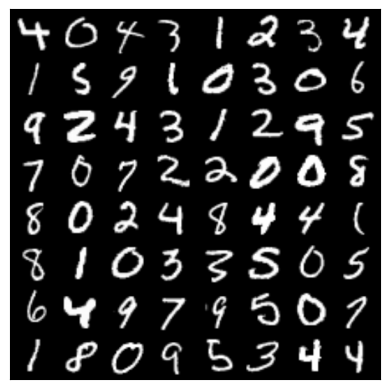

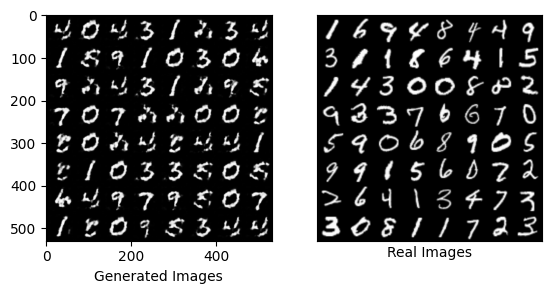

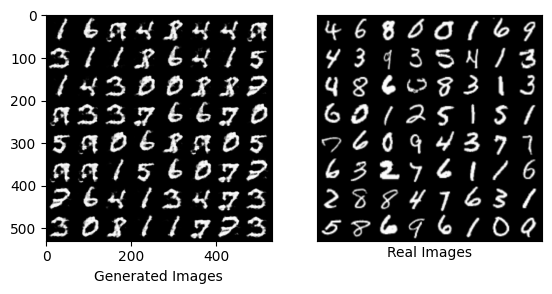

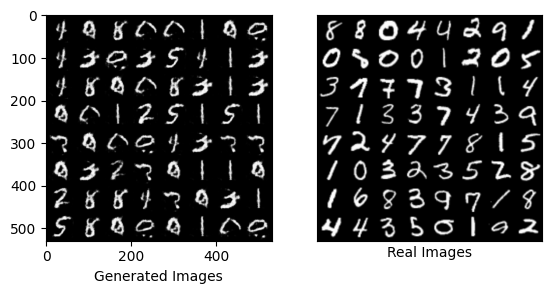

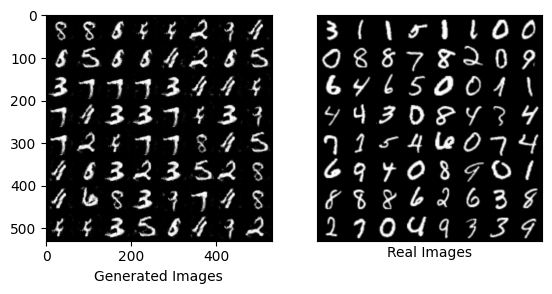

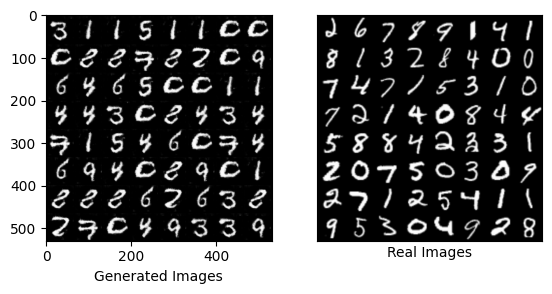

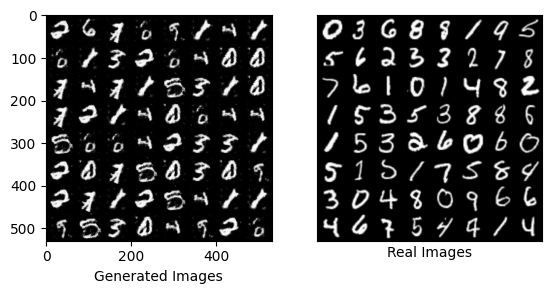

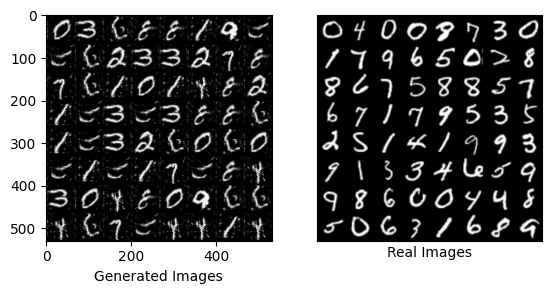

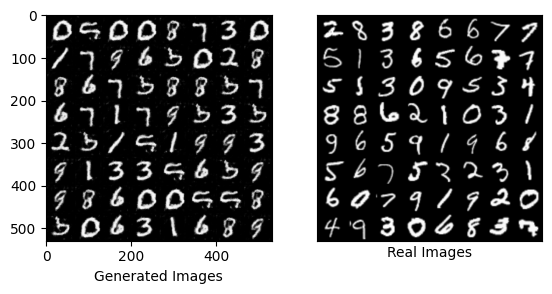

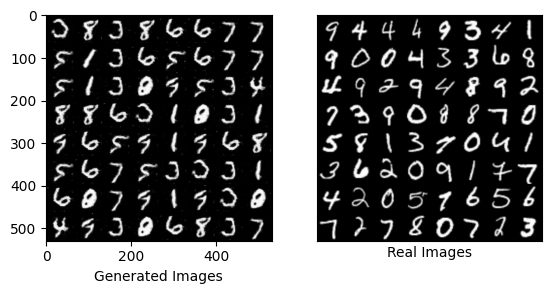

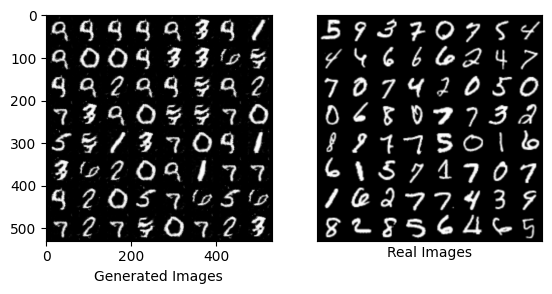

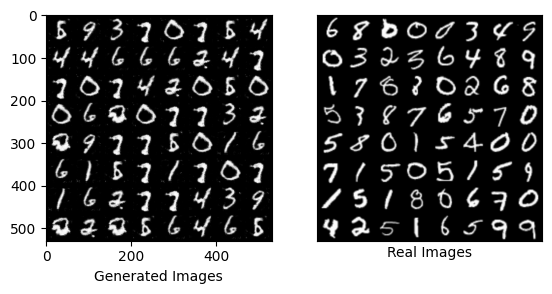

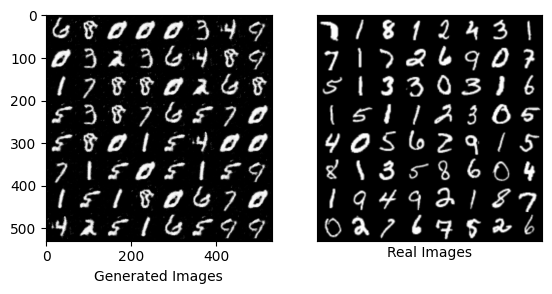

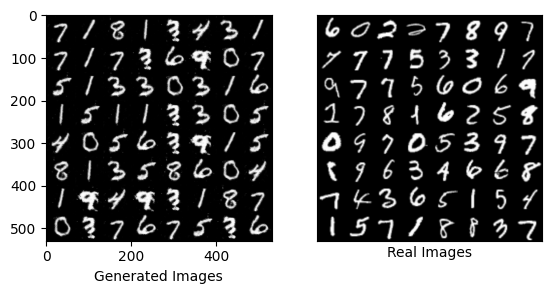

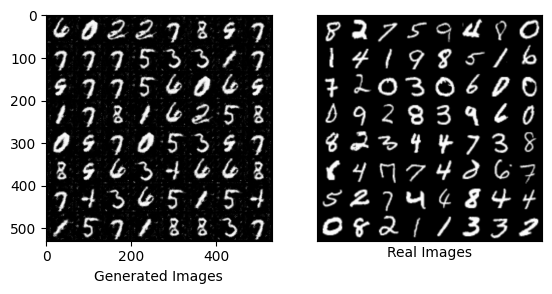

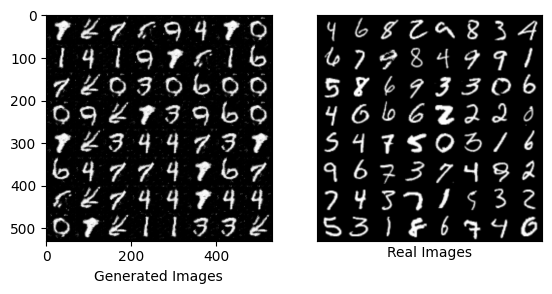

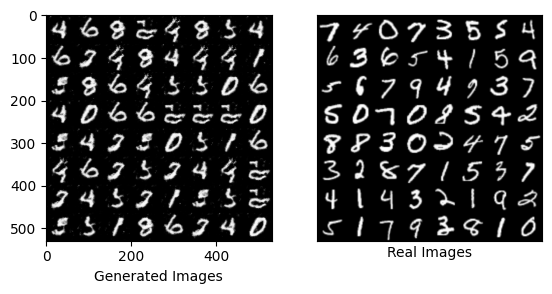

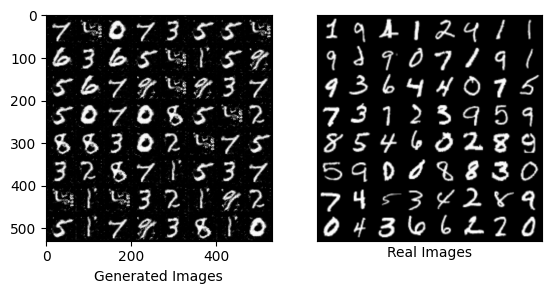

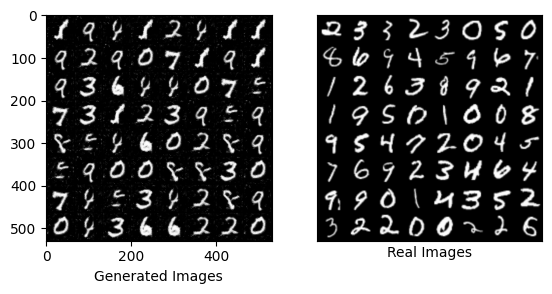

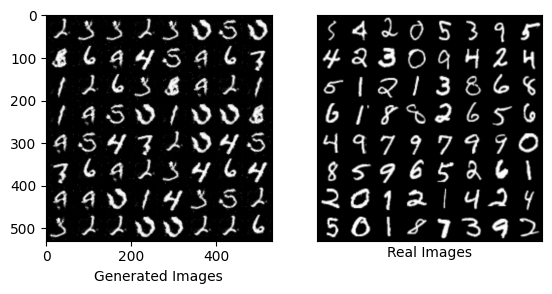

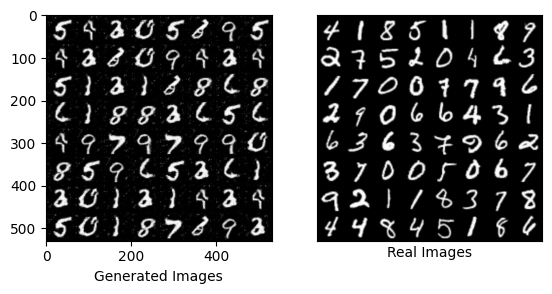

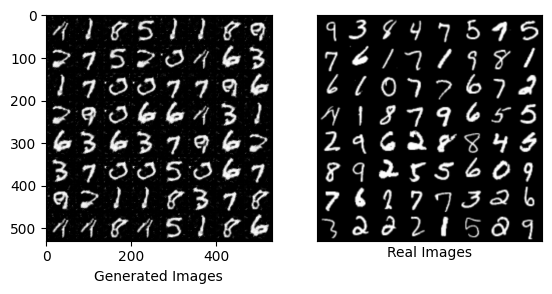

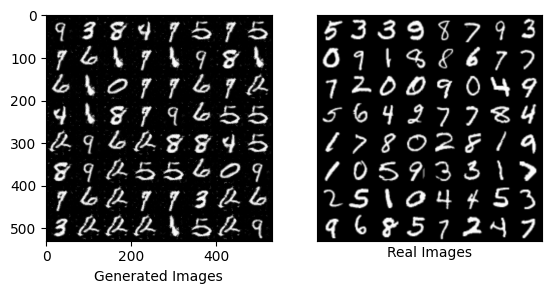

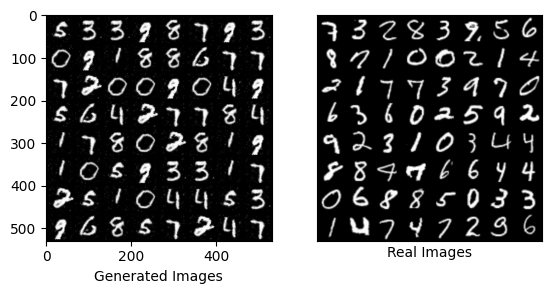

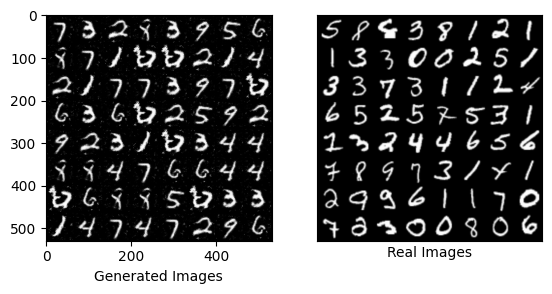

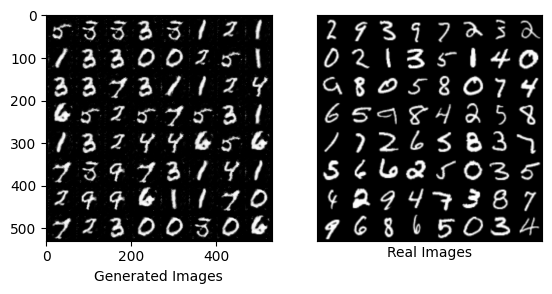

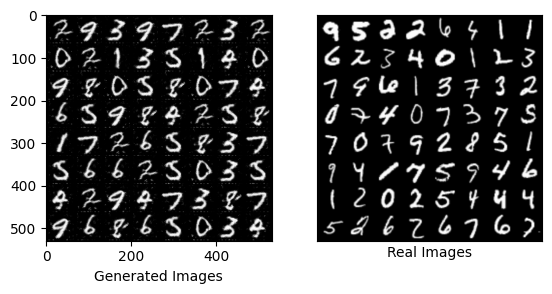

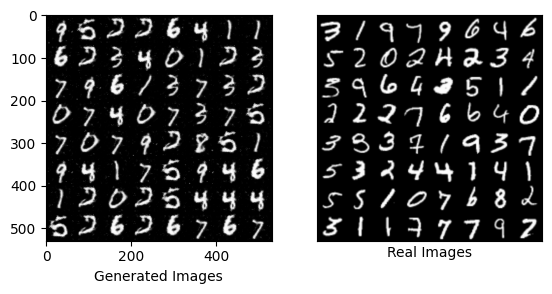

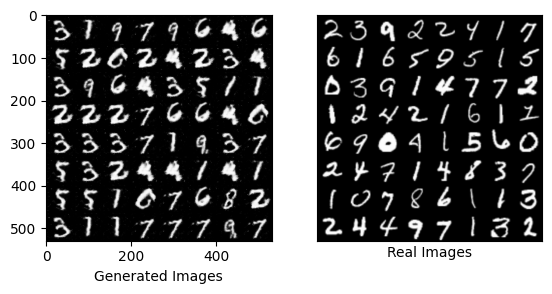

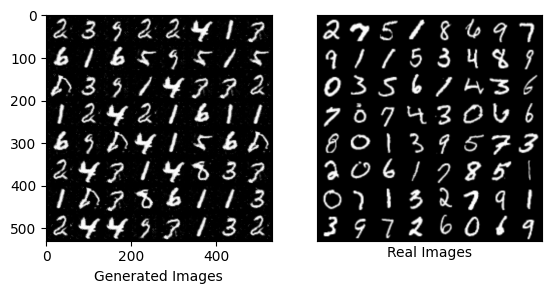

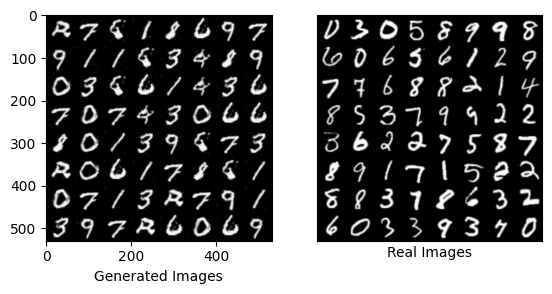

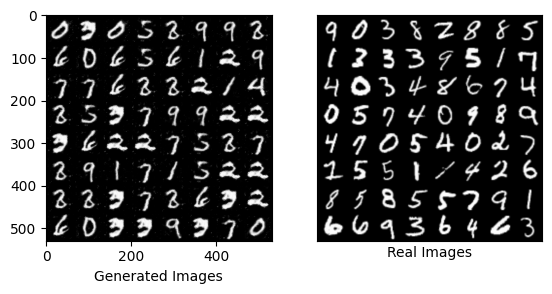

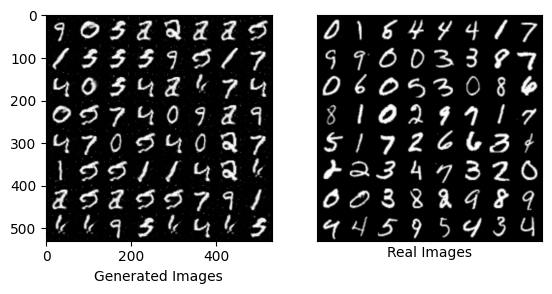

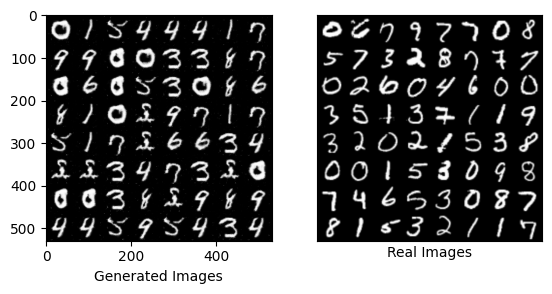

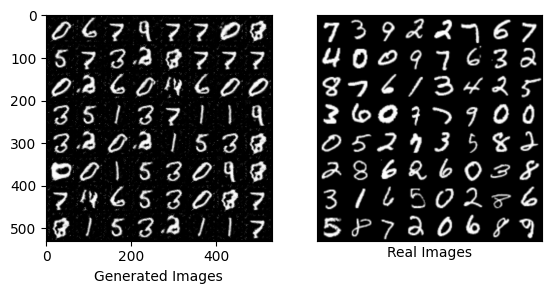

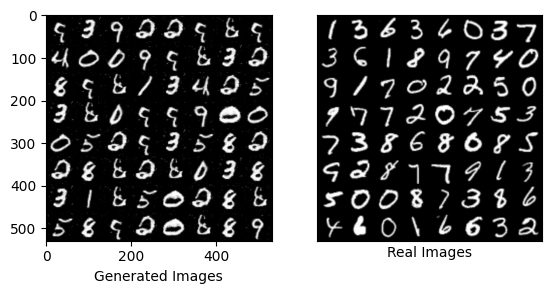

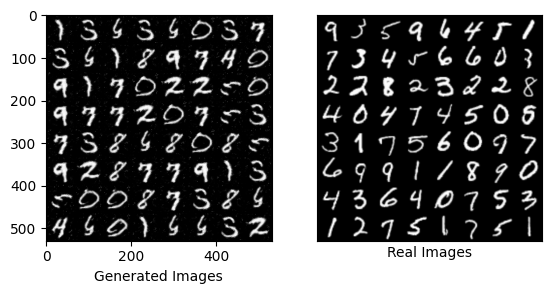

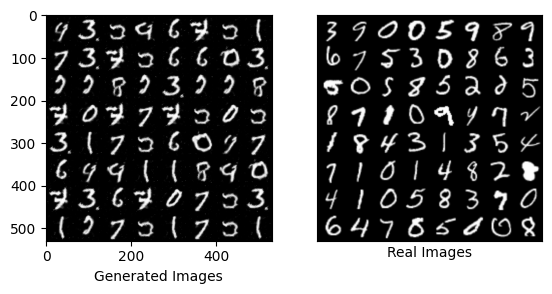

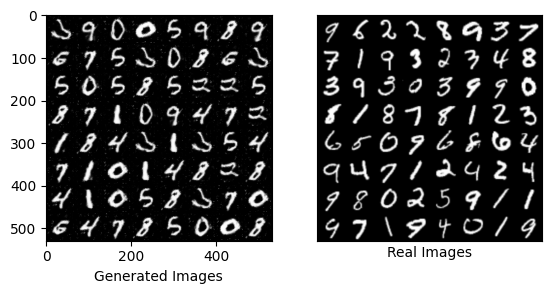

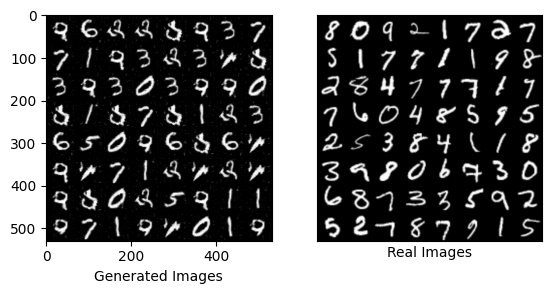

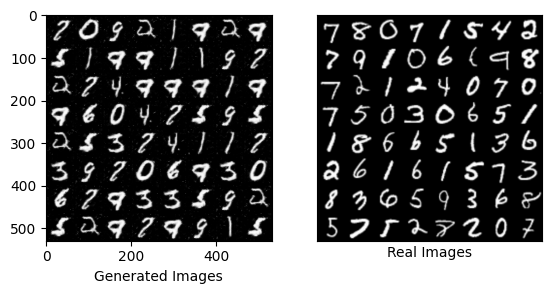

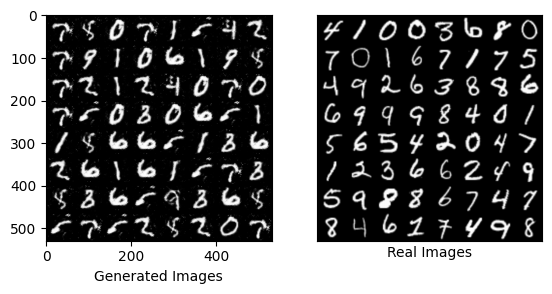

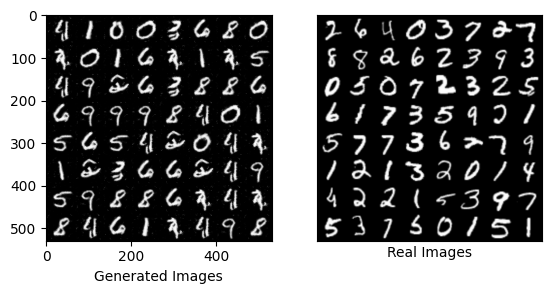

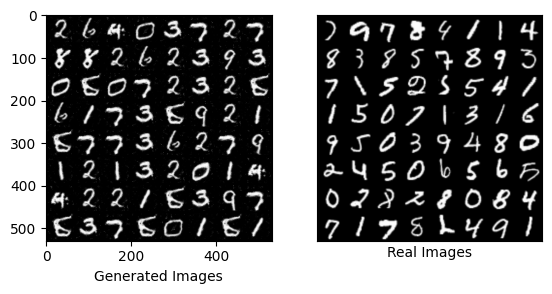

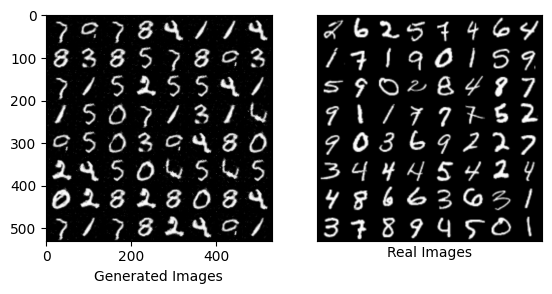

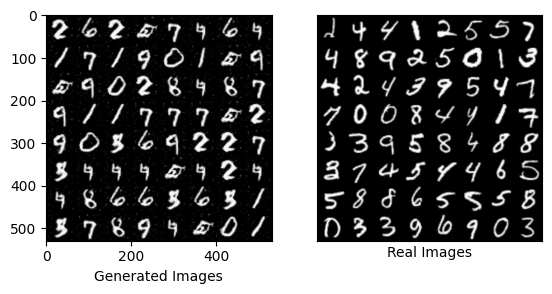

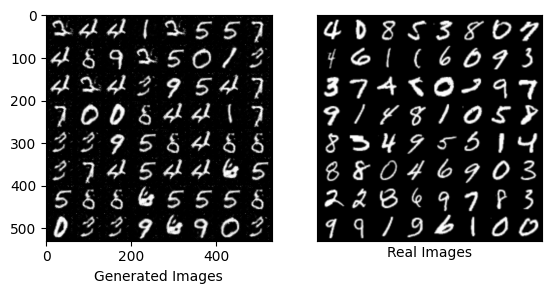

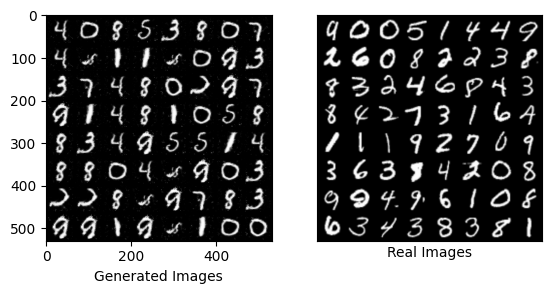

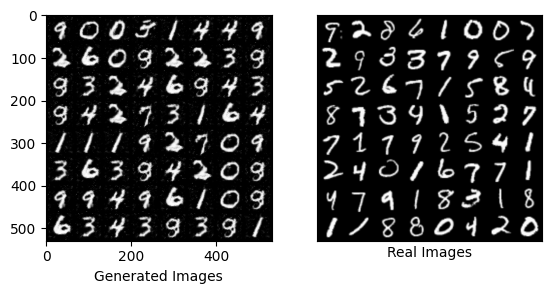

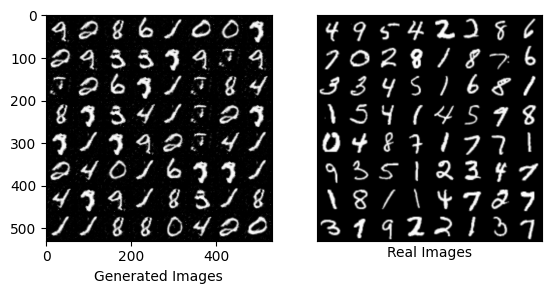

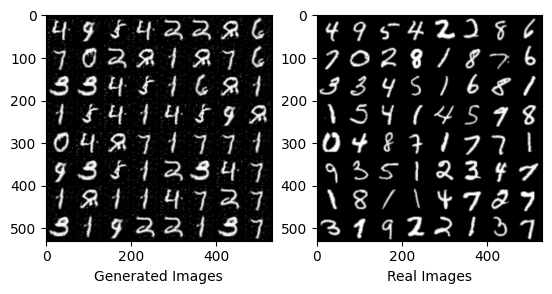

In [17]:
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # TRAINING DISCRIMINATOR
        disc.train()
        disc_optim.zero_grad()
        disc_real_out = disc(images, labels)
        disc_real_loss = criterion(disc_real_out, real_targets)
        
        gen.eval()
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        disc_fake_out = disc(gen(noise, labels), labels)
        disc_fake_loss = criterion(disc_fake_out, fake_targets)
        
        # Total loss
        d_loss = disc_real_loss + disc_fake_loss
        
        # Backprop and Update params
        d_loss.backward()
        disc_optim.step()
        
        # Training Generator
        gen.train()
        gen_optim.zero_grad()
        fake_images = gen(noise, labels)
        g_loss = criterion(disc(fake_images, labels), real_targets)
        
        # Backprop and Update params
        g_loss.backward()
        gen_optim.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'EPOCH: {epoch+1} | G_LOSS: {np.mean(g_losses):.3f} | D_LOSS: {np.mean(d_losses):.3f}')
    
    gen.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    generated_images = gen(fixed_noise,labels)
    fake_images = save_image_grid(epoch, generated_images, 8, type = 'fake')
    real_images = save_image_grid(epoch, images, 8, type = 'real' )
    plot_images(fake_images, real_images, epoch)